In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# Pytorch Gpu Configuration for Cuda
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
import torch_directml

device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

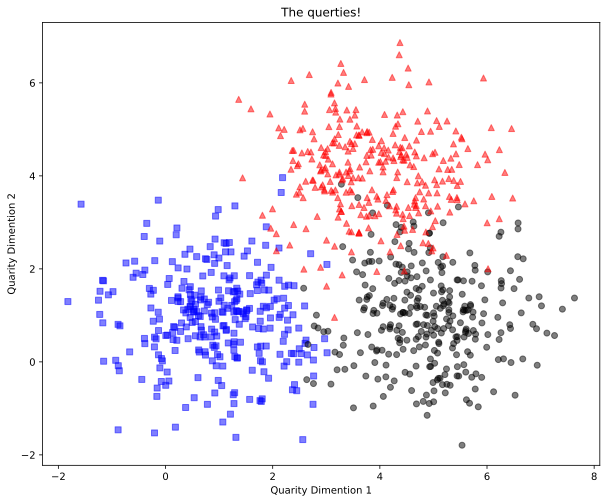

In [2]:
# Create and inspect the data

nPerCluster = 300  ## Change the value to 50 and then 1000 to see the effect on the learning performance
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# Generate the data
a = [
    A[0] + np.random.randn(nPerCluster) * blur,
    A[1] + np.random.randn(nPerCluster) * blur,
]
b = [
    B[0] + np.random.randn(nPerCluster) * blur,
    B[1] + np.random.randn(nPerCluster) * blur,
]
c = [
    C[0] + np.random.randn(nPerCluster) * blur,
    C[1] + np.random.randn(nPerCluster) * blur,
]

# True labels
labels_np = np.hstack(
    (np.zeros((nPerCluster)), np.ones((nPerCluster)), 1 + np.ones((nPerCluster)))
)

# Concat into a matrix
data_np = np.hstack((a, b, c)).T

# Convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: Long format is for Cross Entropy Loss

# Show the data
fig = plt.figure(figsize=(10, 8))
plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 2)[0], 0].cpu(),
    data[np.where(labels.cpu() == 2)[0], 1].cpu(),
    "r^",
    alpha=0.5,
)
plt.title("The querties!")
plt.xlabel("Quarity Dimention 1")
plt.ylabel("Quarity Dimention 2")
plt.show()

In [3]:
# Use scikitlearn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.1
)

# Convert data into pytorch dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Finally translate it into dataloader objects
batchsize = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [76]:
# how many batches are there?

print(f"There are {len(train_loader)} batches, each with {batchsize} samples.")

There are 50 batches, each with 16 samples.


In [19]:
# Create model function
def createTheQuertyNet(momentum):
    # Class for the QuertyNet
    class QuertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2, 8)

            # Hidden Layers
            self.hidden1 = nn.Linear(8, 8)
            self.hidden2 = nn.Linear(8, 8)
            # Output Layer
            self.output = nn.Linear(8, 3)

        # Forwar Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))

            return self.output(x)

    # Model Instance
    net = QuertyNet()

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=momentum)

    return net, lossFun, optimizer

In [20]:
# confirm that the optimizer has momentum
optim = createTheQuertyNet(0.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [25]:
nEpochs = 50


# Function to train the model
def trainTheModel(momentum):
    # Create a new model
    net, lossFun, optimizer = createTheQuertyNet(momentum)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):

        # Switch to training mode
        net.train()

        # Loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss for the batch
            batchLoss.append(loss.item())

            # Comput accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            batchAcc.append(100 * (torch.mean(matchesNumeric)).cpu())

            # End of batch loop
        # Average training accuracy across the batches
        trainAcc.append(np.mean(batchAcc))

        # Average losses across batches
        losses[epoch] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(
            100 * (torch.mean((torch.argmax(yHat, axis=1) == y).float())).cpu()
        )

    # End of epoch

    # Function Output
    return trainAcc, testAcc, losses, net

In [26]:
# Momentum values
# momenta = [0, 0.5, 0.9, 0.95, 0.999]
# momenta = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
momenta = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95]

# Initialize results matrix
results = np.zeros((nEpochs, len(momenta), 3))
# test all momentum values on the same data (different model instances)
for idx, mom in enumerate(momenta):
    trainAcc, testAcc, losses, net = trainTheModel(mom)
    results[:, idx, 0] = losses.cpu()
    results[:, idx, 1] = trainAcc
    results[:, idx, 2] = testAcc

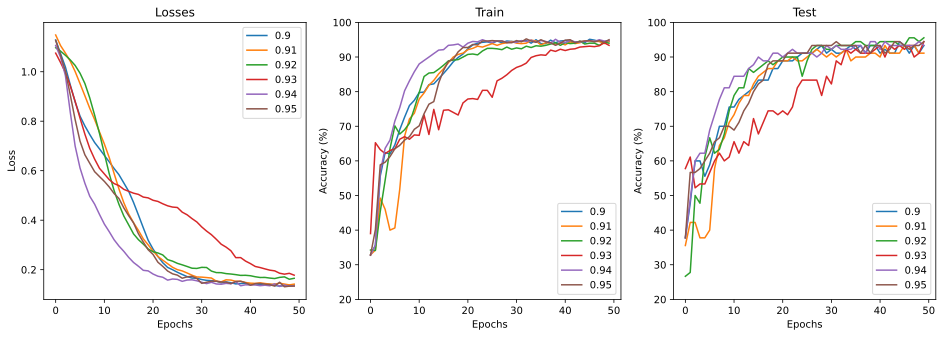

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    ax[i].plot(results[:, :, i])
    ax[i].legend(momenta)
    ax[i].set_xlabel("Epochs")
    if i == 0:
        ax[i].set_ylabel("Loss")
    else:
        ax[i].set_ylabel("Accuracy (%)")
        ax[i].set_ylim([20, 100])

ax[0].set_title("Losses")
ax[1].set_title("Train")
ax[2].set_title("Test")

plt.show()

In [28]:
# 1) Now that you see the results across a broad range of beta (momentum) parameters, try re-running the experiment
#    using a narrower range. For example, you don't need to test b=0 or b=.999.
# ====> For value of beta between 0.9 to 0.99 and reduced model complexity Value of beta between 0.9 and 0.95 does quite well but value > 0.95 are not usable
# 2) The beta parameter multiplies the learning rate in the computation (see formula in slides). That means that these
#    results will interact with the learning rate. Repeat the experiment using a different learning rate.
# ====> Let's try the lr value of 0.001, it needs more epocs to learn and for very small lr it helps to have bigger value of beta
# 3) If you wanted to test the relationship between momentum and learning rate in a full parametric experiment, how would
#    you set it up? Would you store the loss/accuracy over all epochs?
#